# ODE Solver

### Overview
I needed an ODE solver for simulating my electro-mechanical problems (e.g. [inverted pendulum on a cart](https://www.youtube.com/watch?v=nOSTzpA0nGk)). I could use a solver `scipy.integrate.odeint` but for simulating time-dependent functions I needed the derivative function to be called with a fixed-step. I came up with a concise implementatons of solvers of different orders which are explored below.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
plt.style.use('seaborn-whitegrid')

In [2]:
def solve(initial_state, times, integrate_func, derivative_func):
    """
    Solves the initial-value problem of the first order ODEs
    :param initial_state: initial state
    :param times: a sequence of time points for which to solve
    :param integrate_func: calculates the next state
    :param derivative_func: computes derivatives of each state component
    :return:
    """
    dt = times[1] - times[0]
    states = [initial_state]
    for step, t in enumerate(times):
        states.append(integrate_func(states[-1], step, t, dt, derivative_func))
    return np.array(states)

In [3]:
def integrate_euler(state, step, t, dt, dydx_func):
    """
    First-order solver. Uses Euler's method
    :param state: 
    :param step: 
    :param t: 
    :param dt: 
    :param dydx_func: 
    :return: 
    """
    k1 = dydx_func(state, step, t, dt)
    return [v + k1_ * dt for v, k1_ in zip(state, k1)]

In [4]:
def integrate_heuns(state, step, t, dt, dydx_func):
    """
    Second-order Heun's method. 
    Source: https://en.wikipedia.org/wiki/Heun%27s_method
    :param state:
    :param step:
    :param t:
    :param dt:
    :param dydx_func:
    :return:
    """
    k1 = dydx_func(state, step, t, dt)
    k2 = dydx_func([v + d * dt for v, d in zip(state, k1)], step, t, dt)
    return [v + (k1_ + k2_) * dt / 2 for v, k1_, k2_ in zip(state, k1, k2)]


In [5]:
def integrate_rk4(state, step, t, dt, dydx_func):
    """
    Fourth-order Runge-Kutta method.
    Source: https://www.geeksforgeeks.org/runge-kutta-4th-order-method-solve-differential-equation/
    :param step:
    :param state:
    :param t:
    :param dt:
    :param dydx_func:
    :return:
    """
    k1 = dydx_func(state, step, t, dt)
    k2 = dydx_func([v + d * dt / 2 for v, d in zip(state, k1)], step, t, dt)
    k3 = dydx_func([v + d * dt / 2 for v, d in zip(state, k2)], step, t, dt)
    k4 = dydx_func([v + d * dt for v, d in zip(state, k3)], step, t, dt)
    return [v + (k1_ + 2 * k2_ + 2 * k3_ + k4_) * dt / 6 for v, k1_, k2_, k3_, k4_ in zip(state, k1, k2, k3, k4)]


Let's compare these method's precision by solving a model problem, where state is $[x, v]$ and the equations are

$$
\frac{d}{dt}\begin{bmatrix}
x \\
v
\end{bmatrix} = 
\begin{bmatrix}
v \\
-x
\end{bmatrix}
$$

which have the following analytical solution $x(t) = C_1 \cdot cos(t) + i \cdot C_2 \cdot sin(t)$, given the initial condition $[x, v] = [1, 0], x(t) = cos(t)$

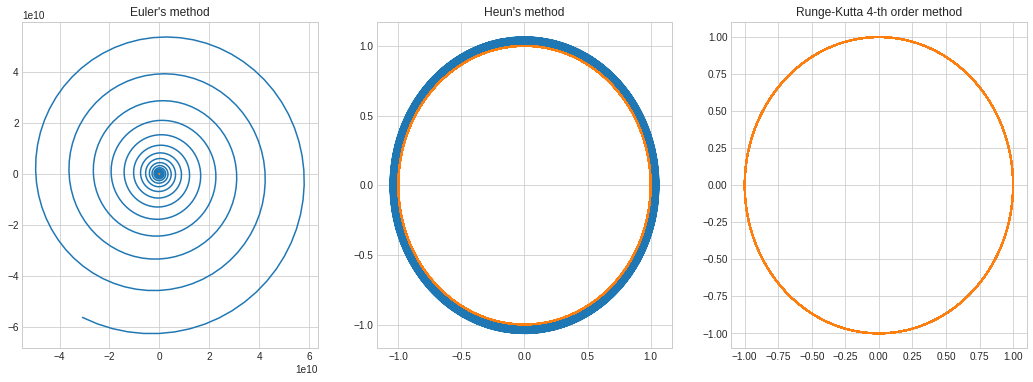

In [6]:
def derivatives_circle(state, step, t, dt):
    x, v = state
    return [v, -x]

initial_state = [1, 0]
times = np.linspace(0, 500, 5000)
euler_solution = solve(initial_state, times, integrate_euler, derivatives_circle)
heuns_solution = solve(initial_state, times, integrate_heuns, derivatives_circle)
rk4_solution = solve(initial_state, times, integrate_rk4, derivatives_circle)

analytical_solution = np.array([np.cos(times), -np.sin(times)]).T

fix, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].plot(euler_solution[:, 0], euler_solution[:, 1])
axs[0].plot(analytical_solution[:, 0], analytical_solution[:, 1])
axs[0].set_title('Euler\'s method')

axs[1].plot(heuns_solution[:, 0], heuns_solution[:, 1])
axs[1].plot(analytical_solution[:, 0], analytical_solution[:, 1])
axs[1].set_title('Heun\'s method')

axs[2].plot(rk4_solution[:, 0], rk4_solution[:, 1])
axs[2].plot(analytical_solution[:, 0], analytical_solution[:, 1])
axs[2].set_title('Runge-Kutta 4-th order method')

plt.show()

In [7]:
# Error estimation
from scipy.integrate import odeint


def derivatives(state, t):
    x, v = state
    return [v, -x]

odeint_solution = odeint(derivatives, initial_state, times)


def get_error(a, b):
    return abs((a - b) / b) * 100

a_last = analytical_solution[-1, 0]
print(f"Euler's method absolute error: {get_error(euler_solution[-1, 0], a_last)}%")
print(f"Heun's method absolute error: {get_error(heuns_solution[-1, 0], a_last)}%")
print(f"RK4 method absolute error: {get_error(rk4_solution[-1, 0], a_last)}%")
print(f"odeint method absolute error: {get_error(odeint_solution[-1, 0], a_last)}%")

Euler's method absolute error: 3483087945970.995%
Heun's method absolute error: 81.68118543663982%
RK4 method absolute error: 5.761704126220804%
odeint method absolute error: 0.0009155837127222461%


### Let's consider some practical examples

- three body problem
- double pendulum problem

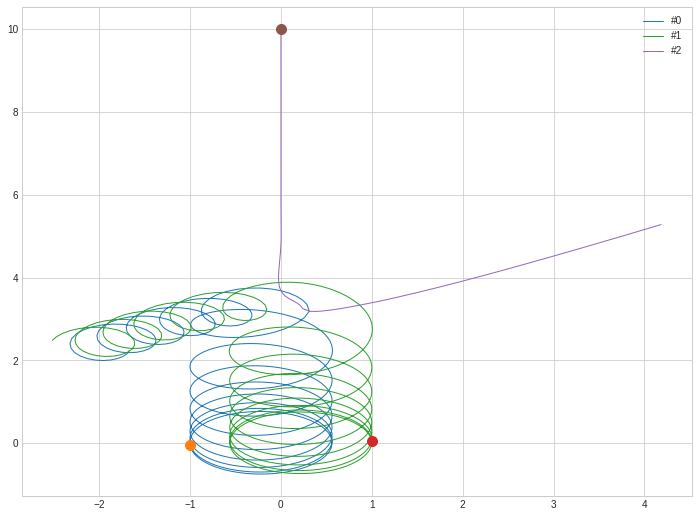

In [8]:
# Three-body problem

from functools import reduce

G = 0.5

times = np.linspace(0, 2.5, 700)

positions = [
    [-1.0, 0.0],
    [1.0, 0.0],
    [0.0, 10.0]
]

velocities = [
    [0.0, -15.0],
    [0.0, 15.0],
    [0.0, 0.0]
]

masses = [50, 50, 4.0]


def to_state(positions_, velocities_):
    return list(reduce(lambda x, y: x + y, map(lambda x: x[0] + x[1], zip(positions_, velocities_)), []))


def derivatives_gravity_n_bodies(state_, step, t_, dt_):
    xs = state_[::4]
    ys = state_[1::4]
    vxs = state_[2::4]
    vys = state_[3::4]
    axs = np.zeros_like(xs)
    ays = np.zeros_like(xs)

    for i in range(len(xs)):
        for j in range(len(xs)):
            if i == j:
                continue

            dist2 = (xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2
            dist = np.sqrt(dist2)

            a = G * masses[i] * masses[j] / dist2

            axs[i] += a * (xs[j] - xs[i]) / dist
            ays[i] += a * (ys[j] - ys[i]) / dist

    positions_ = [list(x) for x in zip(vxs, vys)]
    velocities_ = [list(x) for x in zip(axs, ays)]
    return to_state(positions_, velocities_)


def render(solution_):
    xs = solution_[:, ::4]
    ys = solution_[:, 1::4]

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    objects = []

    for i in range(xs.shape[1]):
        x, y = xs[:, i], ys[:, i]
        plt.plot(x, y, label=f"#{i}", linewidth=1.0)
        obj, = plt.plot([], [], marker='o', markersize=10)
        obj.set_data([], [])
        objects.append(obj)        

    plt.legend()
    plt.grid(True)
    
    def animate(i_):
        for j in range(len(objects)):
            objects[j].set_data(xs[i_, j], ys[i_, j])
        return objects

    ani = animation.FuncAnimation(fig, animate,
                              frames=np.arange(1, len(solution_)),
                              interval=10, blit=True,
                              repeat=False)
    
    
    plt.show()
    return ani


solution = solve(to_state(positions, velocities), times, integrate_rk4, derivatives_gravity_n_bodies)
ani = render(solution)

In [9]:
%time ani.save('three_body_problem.gif', writer='imagemagick', fps=24)

CPU times: user 53.8 s, sys: 1.82 s, total: 55.6 s
Wall time: 3min 22s


### Three body problem animation
![](three_body_problem.gif)

In [10]:
# double pendulum problem
from numpy import pi, sin, cos

# physical constants
g = 9.8
l1 = 0.8
l2 = 0.5
m1 = 1.0
m2 = 0.4

# simulation time
times = np.linspace(0, 20, 400)
dt = times[1] - times[0]

# initial conditions
a0 = pi / 3  # angle of the first pendulum
Y0 = .0  # angular velocity of the first pendulum
b0 = pi / 5  # angle of the second pendulum
Z0 = .0  # angular velocity of the second pendulum

initial_state = np.array([a0, Y0, b0, Z0])


def derivatives(state, step, t_, dt_):
    ds = np.zeros_like(state)
    a = state[0]
    Y = state[1]
    b = state[2]
    Z = state[3]

    ds[0] = Y
    ds[1] = (- m2 * cos(a - b) * (l1 * Y * Y * sin(a - b) - g * sin(a - b)) - Z * Z * l2 * m2 * sin(a - b) - (
            m1 + m2) * g * sin(a)) / (l1 * (m1 + m2 * sin(a - b) * sin(a - b)))
    ds[2] = Z

    h = cos(a - b) / (m1 + m2)
    d = (m1 * l2 + m2 * l2 * sin(a - b) * sin(a - b)) / (m1 + m2)

    ds[3] = (h * (Z * Z * l2 * m2 * sin(a - b) + (m1 + m2) * g * sin(a)) + l1 * Y * Y * sin(a - b) - g * sin(b)) / d

    return ds

solution = solve(initial_state, times, integrate_rk4, derivatives)

alphas = solution[:, 0]
betas = solution[:, 2]

xs1 = l1 * sin(alphas)
ys1 = -l1 * cos(alphas)
xs2 = l2 * sin(betas) + xs1
ys2 = -l2 * cos(betas) + ys1

In [11]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, xs1[i], xs2[i]]
    thisy = [0, ys1[i], ys2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i * dt))
    return line, time_text


ani = animation.FuncAnimation(fig, animate, np.arange(1, len(solution)),
                              interval=25, blit=True, init_func=init)
%matplotlib

Using matplotlib backend: agg


In [12]:
%time ani.save('double_pendulum_problem.gif', writer='imagemagick', fps=24)

CPU times: user 22.1 s, sys: 1.09 s, total: 23.2 s
Wall time: 1min 54s


![](double_pendulum_problem.gif)

### References

- [Source code](https://github.com/zjor/snippets)
- [How to use animation in Kaggle](https://www.kaggle.com/subinium/how-to-use-matplotlib-animations-in-kaggle/)